# 기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 생성하기
## 데이터 준비

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # EOS(end of sentence) 기호 추가

def findFiles(path): return glob.glob(path)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []
for filename in findFiles('../data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


# 네트워크 생성
-   다른 입력들과 연결되는 category tensor를 추가 인자로 가지게 확장(One- Hot 벡터로 구성)
-   출력을 다음 문자의 확률로 해석, 샘플링 할 때, 가장 확률이 높은 문자가 다음 입력 문자로 사용  
![](https://i.imgur.com/jzVrf7f.png)

In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

c:\Users\kimju\OneDrive\바탕 화면\Study\파이썬\machine learning\pytorch_practice\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 학습
## 학습 준비
-   (category, line)의 무작위 쌍을 얻는 함수  
-   각 시계열마다 신경망의 입력은 (언어, 현재 문자, 은닉 상태), 출력은 (다음 문자, 다음 은닉 상태가 된다.)  

  ![](https://i.imgur.com/JH58tXY.png)

In [8]:
import random

# 목록에서 무작위 아이템 반환
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 임의의 category 및 그 category에서 무작위 줄(이름) 얻기
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# Category를 위한 One-hot 벡터
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 입력을 위한 처음부터 마지막 문자(EOS 제외)까지의  One-hot 행렬
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 목표를 위한 두번째 문자 부터 마지막(EOS) 까지의 LongTensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [4]:
# 임의의 Category에서 Category, Input, Target Tensor를 만듭니다.
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

# 네트워크 학습
-   마지막 출력만 사용하는 분류와 달리, 모든 단계에서 예측을 수행하므로 모든 단계에서 손실을 계산해야 한다.
-   AutoGrad가 각 단계의 손실들을 간단하게 합하고 마지막에 역전파를 호출하게 해준다.

In [5]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [6]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [9]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # plot_every 마다 초기화

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 4s (5000 5%) 2.5770
0m 9s (10000 10%) 2.4098
0m 14s (15000 15%) 2.0994
0m 19s (20000 20%) 1.7563
0m 23s (25000 25%) 2.5543
0m 28s (30000 30%) 2.7412
0m 33s (35000 35%) 2.0479
0m 38s (40000 40%) 2.0565
0m 42s (45000 45%) 2.2657
0m 47s (50000 50%) 2.1770
0m 52s (55000 55%) 2.4071
0m 57s (60000 60%) 2.5853
1m 1s (65000 65%) 2.1580
1m 6s (70000 70%) 2.2868
1m 11s (75000 75%) 2.7015
1m 15s (80000 80%) 2.4684
1m 20s (85000 85%) 2.7712
1m 25s (90000 90%) 1.5438
1m 30s (95000 95%) 1.7397
1m 34s (100000 100%) 3.8865


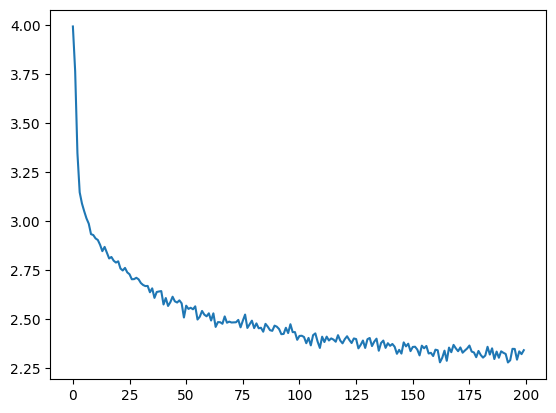

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

# 신경망 샘플링
-   신경망에 하나의 글자를 주고 다음 문자를 물어보고 이것을 다음 문자로 전달하는 것을 EOS 토큰까지 반복
    -   입력 카테고리(언어), 시작 문자, 비어 있는 은닉 상태를 위한 Tensor를 생성
    -   시작 문자로 output_name 문자열을 생성
    -   최대 출력 길이까지,
        -   현재 문자를 네트워크에 전달
        -   가장 높은 출력에서 다음 문자와 다음 은닉 상태를 얻음
        -   만일 문자가 EOS라면, 멈춤
        -   만일 일반적인 문자라면, output_name에 추가하고 계속
    -   마지막 이름을 반환

In [11]:
max_length = 20

# 카테고리와 시작 문자로 부터 샘플링 하기
def sample(category, start_letter='A'):
    with torch.no_grad():  # 샘플링에서 히스토리를 추적할 필요 없음
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

In [13]:
# 하나의 카테고리와 여러 시작 문자들로 여러 개의 샘플 얻기
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

samples('Korean', 'KOR')

Roshin
Uantono
Santovak
Gerter
Ererter
Ronger
Santer
Pare
Allasa
Can
Han
Iun
Kon
Oong
Ruon
